In [1]:
using Distributed
addprocs(8);

In [2]:
@everywhere using PulseInputDDM, MAT
import Statistics: mean

In [3]:
ratnames = ["B068","T034","T036","T063","T030", "T035","T011","B053", "T080","T103","E021"];
dt, n, cross = 1e-2, 53, false
data_path = joinpath(abspath(joinpath(pwd(), "..")), "data/by_session");

In [4]:
region, delay = "FOF", 6
ratnum = 1:5
rat = ratnames[ratnum]
sessions = vcat(map(rat-> filter(x->occursin(rat,x), readdir(data_path)), rat)...);
data_FOF, = load_neural_data(joinpath.(data_path, sessions), pcut=0.01, pad=20, delay=delay, dt=dt, 
    filtSD=5, do_RBF=true);
ntrials_FOF = sum(length.(data_FOF));

In [5]:
region, delay = "ADS", 6
ratnum = 9:11
rat = ratnames[ratnum]
sessions = vcat(map(rat-> filter(x->occursin(rat,x), readdir(data_path)), rat)...);
data_STR, = load_neural_data(joinpath.(data_path, sessions), pcut=0.01, pad=20, delay=delay, dt=dt, 
    filtSD=5, do_RBF=true);
ntrials_STR = sum(length.(data_STR));

In [6]:
joint_model_path = joinpath(abspath(joinpath(pwd(), "..")), "models/joint-folds");

In [7]:
import Base.Iterators: partition

In [8]:
LL_joint_FOF_folds = Vector{Float64}(undef,5)
joint_model_folds_FOF = Vector(undef,5)
region = "FOF"
ntrials = length.(data_FOF);

for fold in 1:5
    
    train = map(ntrials -> vcat(collect.(partition(1:ntrials, ceil(Int, ntrials/5)))[setdiff(1:5, fold)]...), ntrials)
    test = map((ntrials, train)-> setdiff(1:ntrials, train), ntrials, train)
    test_data_FOF = map((data, train)-> data[train], data_FOF, test)

    file = joinpath(joint_model_path, region*"_"*string(fold)*".mat")
    xfolds = read(matopen(file), "ML_params");
    f = all_Softplus(data_FOF)  

    joint_model_folds_FOF[fold] = neural_choiceDDM(θneural_choice(xfolds, f), n, cross);

    LL_joint_FOF_folds[fold] = (PulseInputDDM.joint_loglikelihood(joint_model_folds_FOF[fold], test_data_FOF))/(log(2) * 
        length(getfield.(vcat(test_data_FOF...), :choice)));
    
end

In [9]:
LL_joint_STR_folds = Vector{Float64}(undef,5)
joint_model_folds_STR = Vector(undef,5)
region = "ADS"
ntrials = length.(data_STR);

for fold in 1:5
    
    train = map(ntrials -> vcat(collect.(partition(1:ntrials, ceil(Int, ntrials/5)))[setdiff(1:5, fold)]...), ntrials)
    test = map((ntrials, train)-> setdiff(1:ntrials, train), ntrials, train)
    test_data_STR = map((data, train)-> data[train], data_STR, test)

    file = joinpath(joint_model_path, region*"_"*string(fold)*".mat")
    xfolds = read(matopen(file), "ML_params");
    f = all_Softplus(data_STR)  

    joint_model_folds_STR[fold] = neural_choiceDDM(θneural_choice(xfolds, f), n, cross);

    LL_joint_STR_folds[fold] = (PulseInputDDM.joint_loglikelihood(joint_model_folds_STR[fold], test_data_STR))/(log(2) * 
        length(getfield.(vcat(test_data_STR...), :choice)));
    
end

## Independent model

In [10]:
independent_model_path = joinpath(abspath(joinpath(pwd(), "..")), "models/independent-folds");

In [11]:
import DePasqualeElife2024: sep_joint_loglikelihood

In [12]:
LL_joint_FOF_folds_sep = Vector{Float64}(undef,5)
joint_model_folds_FOF_sep = Vector(undef,5)
region = "FOF"
ntrials = length.(data_FOF);

for fold in 1:5
    
    train = map(ntrials -> vcat(collect.(partition(1:ntrials, ceil(Int, ntrials/5)))[setdiff(1:5, fold)]...), ntrials)
    test = map((ntrials, train)-> setdiff(1:ntrials, train), ntrials, train)
    test_data_FOF = map((data, train)-> data[train], data_FOF, test)

    file = joinpath(independent_model_path, region*"_"*string(fold)*".mat")
    xfolds = read(matopen(file), "ML_params");
    f = all_Softplus(data_FOF)  

    joint_model_folds_FOF_sep[fold] = neural_choiceDDM(θneural_choice(xfolds, f), n, cross);

    LL_joint_FOF_folds_sep[fold] = (sep_joint_loglikelihood(joint_model_folds_FOF_sep[fold], test_data_FOF))/(log(2) * 
        length(vcat(test...)));
    
end

In [13]:
LL_joint_STR_folds_sep = Vector{Float64}(undef,5)
joint_model_folds_STR_sep = Vector(undef,5)
region = "ADS"
ntrials = length.(data_STR);

for fold in 1:5
    
    train = map(ntrials -> vcat(collect.(partition(1:ntrials, ceil(Int, ntrials/5)))[setdiff(1:5, fold)]...), ntrials)
    test = map((ntrials, train)-> setdiff(1:ntrials, train), ntrials, train)
    test_data_STR = map((data, train)-> data[train], data_STR, test)

    file = joinpath(independent_model_path, region*"_"*string(fold)*".mat")
    xfolds = read(matopen(file), "ML_params");
    f = all_Softplus(data_STR)  

    joint_model_folds_STR_sep[fold] = neural_choiceDDM(θneural_choice(xfolds, f), n, cross);

    LL_joint_STR_folds_sep[fold] = (sep_joint_loglikelihood(joint_model_folds_STR_sep[fold], test_data_STR))/(log(2) * 
        length(vcat(test...)));
    
end

## Neural data only models

In [14]:
neural_model_path = joinpath(abspath(joinpath(pwd(), "..")), "models/neural-folds");

In [15]:
LL_neural_STR_folds = Vector{Float64}(undef,5)
neural_model_folds_STR = Vector(undef,5);

region = "ADS"
ntrials = length.(data_STR);

for fold in 1:5
    
    train = map(ntrials -> vcat(collect.(partition(1:ntrials, ceil(Int, ntrials/5)))[setdiff(1:5, fold)]...), ntrials)
    test = map((ntrials, train)-> setdiff(1:ntrials, train), ntrials, train)
    test_data_STR = map((data, train)-> data[train], data_STR, test)
    train_data_STR = map((data, train)-> data[train], data_STR, train)

    file = joinpath(neural_model_path, region*"_"*string(fold)*".mat")
    xfolds = read(matopen(file), "ML_params");
    
    f = all_Softplus(data_STR)      
    neural_model_folds_STR[fold] = neuralDDM(θ=θneural(xfolds, f), n=n, cross=cross);     
    LL_neural_STR_folds[fold] = (PulseInputDDM.loglikelihood(neural_model_folds_STR[fold], test_data_STR))/(log(2) * 
        length(getfield.(vcat(test_data_STR...), :choice)));
    
end

In [16]:
LL_neural_FOF_folds = Vector{Float64}(undef,5)
neural_model_folds_FOF = Vector(undef,5)

region = "FOF"
ntrials = length.(data_FOF);

for fold in 1:5
    
    train = map(ntrials -> vcat(collect.(partition(1:ntrials, ceil(Int, ntrials/5)))[setdiff(1:5, fold)]...), ntrials)
    test = map((ntrials, train)-> setdiff(1:ntrials, train), ntrials, train)
    test_data_FOF = map((data, train)-> data[train], data_FOF, test)
    train_data_FOF = map((data, train)-> data[train], data_FOF, train)

    file = joinpath(neural_model_path, region*"_"*string(fold)*".mat")
    xfolds = read(matopen(file), "ML_params");
    
    f = all_Softplus(data_FOF)      
    neural_model_folds_FOF[fold] = neuralDDM(θ=θneural(xfolds, f), n=n, cross=cross);     
    LL_neural_FOF_folds[fold] = (PulseInputDDM.loglikelihood(neural_model_folds_FOF[fold], test_data_FOF))/(log(2) * 
        length(getfield.(vcat(test_data_FOF...), :choice)));
    
end

In [17]:
import DePasqualeElife2024: sep_neural_loglikelihood

In [18]:
LL_neural_FOF_folds_sep = Vector{Float64}(undef,5)
neural_model_folds_FOF_sep = Vector(undef,5)

region = "FOF"
ntrials = length.(data_FOF);

for fold in 1:5
    
    train = map(ntrials -> vcat(collect.(partition(1:ntrials, ceil(Int, ntrials/5)))[setdiff(1:5, fold)]...), ntrials)
    test = map((ntrials, train)-> setdiff(1:ntrials, train), ntrials, train)
    test_data_FOF = map((data, train)-> data[train], data_FOF, test)
    train_data_FOF = map((data, train)-> data[train], data_FOF, train)

    file = joinpath(neural_model_path, region*"_"*string(fold)*"_ind.mat")
    xfolds = read(matopen(file), "ML_params");  
    
    f = all_Softplus(data_FOF)      
    
    neural_model_folds_FOF_sep[fold] = neuralDDM(θ=θneural(xfolds, f), n=n, cross=cross);

    LL_neural_FOF_folds_sep[fold] = (sep_neural_loglikelihood(neural_model_folds_FOF_sep[fold], test_data_FOF))/(log(2) * 
        length(getfield.(vcat(test_data_FOF...), :choice)));
    
end

In [19]:
LL_neural_STR_folds_sep = Vector{Float64}(undef,5)
neural_model_folds_STR_sep = Vector(undef,5)

region = "ADS"
ntrials = length.(data_STR);

for fold in 1:5
    
    train = map(ntrials -> vcat(collect.(partition(1:ntrials, ceil(Int, ntrials/5)))[setdiff(1:5, fold)]...), ntrials)
    test = map((ntrials, train)-> setdiff(1:ntrials, train), ntrials, train)
    test_data_STR = map((data, train)-> data[train], data_STR, test)
    train_data_STR = map((data, train)-> data[train], data_STR, train)

    file = joinpath(neural_model_path, region*"_"*string(fold)*"_ind.mat")
    xfolds = read(matopen(file), "ML_params");

    f = all_Softplus(data_STR)      
    
    neural_model_folds_STR_sep[fold] = neuralDDM(θ=θneural(xfolds, f), n=n, cross=cross);

    LL_neural_STR_folds_sep[fold] = (sep_neural_loglikelihood(neural_model_folds_STR_sep[fold], test_data_STR))/(log(2) * 
        length(getfield.(vcat(test_data_STR...), :choice)));
    
end

In [20]:
using PyPlot

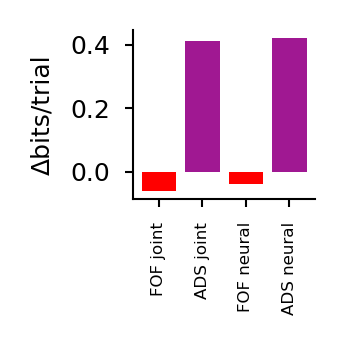

In [21]:
figure(figsize=(1.25, 1.25), dpi=300, frameon=true)

mycolors = ["red", "#A01892"]
rc("xtick", labelsize=6)
rc("ytick", labelsize=6)

bar(1, mean(LL_joint_FOF_folds_sep - LL_joint_FOF_folds), color=mycolors[1]);
bar(2, mean(LL_joint_STR_folds_sep - LL_joint_STR_folds), color=mycolors[2]);

bar(3, mean(LL_neural_FOF_folds_sep - LL_neural_FOF_folds), color=mycolors[1]);
bar(4, mean(LL_neural_STR_folds_sep - LL_neural_STR_folds), color=mycolors[2]);
xticks([1, 2, 3, 4], ["FOF joint", "ADS joint", "FOF neural", "ADS neural"], rotation=90, fontsize=4)
ylabel("Δbits/trial", fontsize=6);

ax = gca()
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
ax.spines["bottom"].set_linewidth(0.5)
ax.spines["left"].set_linewidth(0.5)
ax.tick_params(width=0.5, length=2)
ax.tick_params(which="minor", width=0.5, length=1.5)

tight_layout()
display(gcf())
close(gcf())
#PyPlot.savefig(joinpath(abspath(joinpath(pwd(), "..")), "figs/Supp/")*"SFig5D.pdf")